# AI/ML 4 Climate Change - Exercise 2
### WS 2022 - TU Wien



In [1]:
import glob
import random
import pandas as pd
from IPython.display import Image

from functools import partial
from multiprocessing import Pool

import numpy as np

import sklearn.linear_model
from sklearn.model_selection import train_test_split

# The LAMAH Data 

In [2]:
Image(url="https://zenodo.org/api/iiif/v2/5e7b63a7-7bea-46f6-a8ac-00d63e3cb9b1:c5697b0f-87ce-4b8d-94b2-a8296e3367d1:LamaH_banner.png/full/750,/0/default.png", width=500, height=500)

In [3]:
# Getting the dataset
#import requests
#URL = "https://zenodo.org/record/5153305/files/2_LamaH-CE_daily.tar.gz?download=1"
#response = requests.get(URL)
#open("instagram.ico", "wb").write(response.content)


# Reading the data

It is assumed that the data donwloaded and extracted from the LAMAH datset are structured as follows:

- the directory *A_basins_total_upstream/2_timeseries/daily* containiing the full time series data for each gauge e.g. "ID_1.csv"

- the directory *D_gauges/1_attributes* containing the file with the gauge metadata "Gauge_attributes.csv" 

In [2]:
# time series files
path = 'A_basins_total_upstrm/2_timeseries/daily'
files = glob.glob(path+'/*')

## Reading gauge attributes 
Here we read the attirbutes of the gagues, such as the location and elevation.

MUST FIX the coordinates between two different systems 
i.e. https://gis.stackexchange.com/questions/226892/converting-epsg2284-to-epsg4326-with-pyproj


In [5]:
# Read gauges attributes
path_attr = 'D_gauges/1_attributes/Gauge_attributes.csv'
df_attr = pd.read_csv(path_attr, sep = ';')
df_attr['lat'] = [  str(l)[0:2] + '.' + str(l)[2:4] for l in df_attr.lat.values ]
df_attr['lon'] = [  str(l)[0:2] + '.' + str(l)[2:4] for l in df_attr.lon.values ]

In [6]:
# Inspecting gauge attributes
print(df_attr.columns)
df_attr.head(5)

Index(['ID', 'govnr', 'name', 'river', 'area_gov', 'elev', 'lon', 'lat',
       'country', 'fedstate', 'region', 'obsbeg_day', 'obsbeg_hr', 'obsend',
       'gaps_pre', 'gaps_post', 'area_ratio', 'nrs_euhyd', 'nrs_rivat',
       'typimpact', 'diur_art', 'diur_glac', 'degimpact'],
      dtype='object')


ID   govnr                 name   river  area_gov  elev    lon    lat  \
0   1  200014                Bangs   Rhein    4647.9   420  42.85  26.84   
1   2  200048  Schruns (Vonbunweg)    Litz     102.0   673  43.14  26.62   
2   3  231662        Loruens-Aeule     Ill     535.2   579  43.09  26.68   
3   4  200592    Kloesterle (OEBB)  Alfenz      66.6  1014  43.25  26.68   
4   5  200097  Buers (Bruecke L82)  Alvier      72.2   564  43.06  26.70   

  country fedstate  ... obsend  gaps_pre  gaps_post  area_ratio   nrs_euhyd  \
0     AUT      VBG  ...      0     0.000        0.0       1.004  RL26007414   
1     AUT      VBG  ...      0     0.000        0.0       1.003  RL26006574   
2     AUT      VBG  ...      0     0.000        0.0       1.002  RL26006800   
3     AUT      VBG  ...      0     0.034        0.0       0.995  RL26006781   
4     AUT      VBG  ...      0     0.000        0.0       1.003  RL26006921   

    nrs_rivat  typimpact diur_art  diur_glac degimpact  
0  20447278.0          A        1          0         s  
1  20452702.0          -        0          0         l  
2  20451771.0        A,I        1          0         s  
3  20451185.0          A        1          0         s  
4  20450952.0        E,F        0          0         s  

[5 rows x 23 columns]

In [7]:
print(df_attr.columns)
df_attr.head(5)

Index(['ID', 'govnr', 'name', 'river', 'area_gov', 'elev', 'lon', 'lat',
       'country', 'fedstate', 'region', 'obsbeg_day', 'obsbeg_hr', 'obsend',
       'gaps_pre', 'gaps_post', 'area_ratio', 'nrs_euhyd', 'nrs_rivat',
       'typimpact', 'diur_art', 'diur_glac', 'degimpact'],
      dtype='object')


ID   govnr                 name   river  area_gov  elev    lon    lat  \
0   1  200014                Bangs   Rhein    4647.9   420  42.85  26.84   
1   2  200048  Schruns (Vonbunweg)    Litz     102.0   673  43.14  26.62   
2   3  231662        Loruens-Aeule     Ill     535.2   579  43.09  26.68   
3   4  200592    Kloesterle (OEBB)  Alfenz      66.6  1014  43.25  26.68   
4   5  200097  Buers (Bruecke L82)  Alvier      72.2   564  43.06  26.70   

  country fedstate  ... obsend  gaps_pre  gaps_post  area_ratio   nrs_euhyd  \
0     AUT      VBG  ...      0     0.000        0.0       1.004  RL26007414   
1     AUT      VBG  ...      0     0.000        0.0       1.003  RL26006574   
2     AUT      VBG  ...      0     0.000        0.0       1.002  RL26006800   
3     AUT      VBG  ...      0     0.034        0.0       0.995  RL26006781   
4     AUT      VBG  ...      0     0.000        0.0       1.003  RL26006921   

    nrs_rivat  typimpact diur_art  diur_glac degimpact  
0  20447278.0          A        1          0         s  
1  20452702.0          -        0          0         l  
2  20451771.0        A,I        1          0         s  
3  20451185.0          A        1          0         s  
4  20450952.0        E,F        0          0         s  

[5 rows x 23 columns]

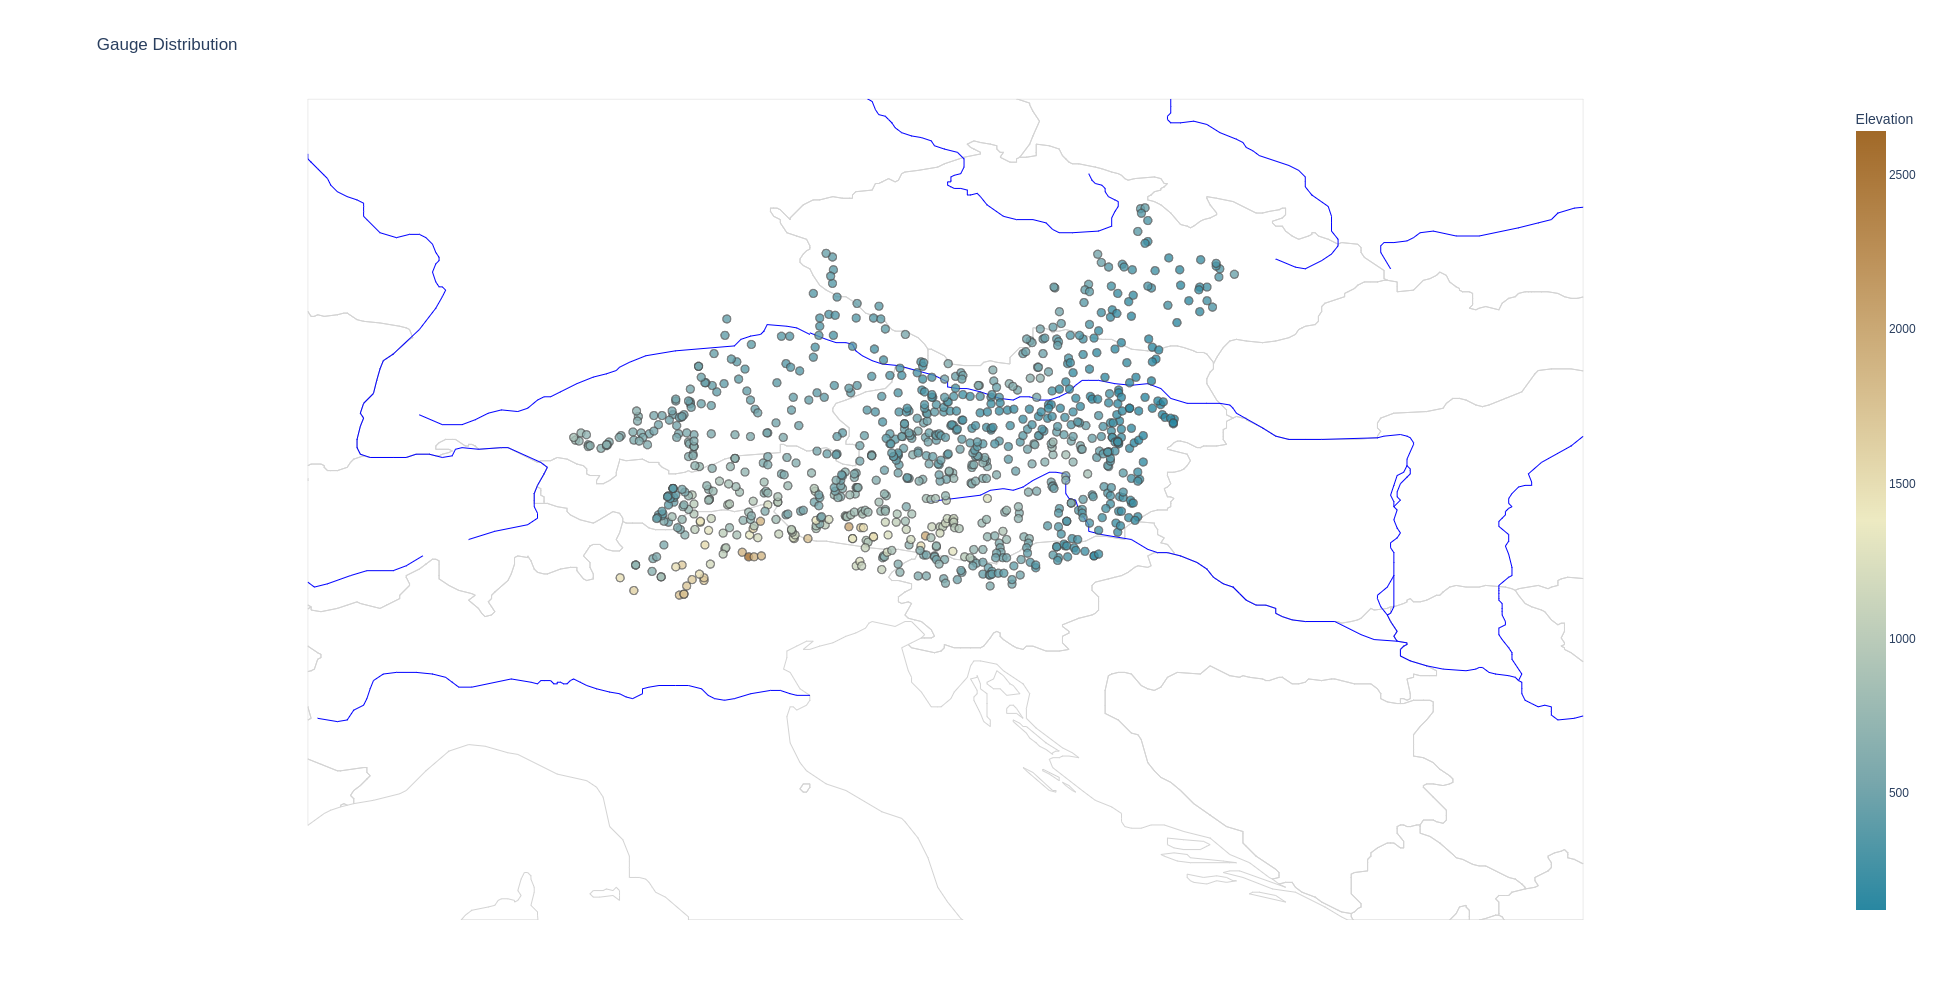

In [8]:
import plotly.graph_objects as go
import plotly.express as px


df_attr['lat_true'] = [float(l) + 20.1 for l in df_attr.lat] 
df_attr['lon_true'] = [float(l) -32 for l in df_attr.lon] 


fig = go.Figure(data=go.Scattergeo(
        lon = df_attr['lon_true'],
        lat = df_attr['lat_true'],
        #text = df['text'],
        mode = 'markers',
            marker = dict(
            size = 8,
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            #colorscale = px.colors.diverging.BrBG,
            colorscale = 'Earth',
                
            colorbar_title="Elevation"

    ),
        marker_color = df_attr['elev'],

        #color_continuous_scale=px.colors.diverging.BrBG,

        ))

fig.update_layout(
        title = 'Gauge Distribution',
        height=1000, width=1800,
  
)

fig.update_geos(
    visible=False, resolution=50,
    showcountries=True, countrycolor="lightgray",
    showrivers=True, rivercolor="Blue",
    center=dict(lon=14, lat=47),
    #projection_rotation=dict(lon=30, lat=30, roll=30),
    lataxis_range=[45,54], lonaxis_range=[5, 19]
)

#fig.update_layout(coloraxis=dict(colorscale='Bluered_r'), showlegend=True)

fig.show()

In [9]:
# Reading example with pandas
import datetime
def read_df(file):
    """ Reads the dataframe from csv files """
    
    df = pd.read_csv(file, sep = ';')
    
    #dt = [ pd.to_datetime( df.YYYY.values[i] + df.MM.values[i] + df.DD.values[i], format='Ymd', errors='ignore') for i in range(len(df.YYYY.values)) ] 
    
    # Create date-time objects (for plotly)
    dt = [datetime.datetime(df.YYYY.values[i], df.MM.values[i] , df.DD.values[i]) for i in range(len(df.YYYY.values))  ]
    df['date_time'] = dt
    
    
    # TO DO add 
    return df



# read one file as example
df = read_df(files[0])
# check columns
# df.columns

In [10]:
#df.columns

In [11]:
df.head()

YYYY  MM  DD  DOY  2m_temp_max  2m_temp_mean  2m_temp_min  2m_dp_temp_max  \
0  1981   1   1    1         -7.1          -8.8        -10.8            -9.2   
1  1981   1   2    2         -7.9          -9.7        -11.5           -10.0   
2  1981   1   3    3         -3.1          -5.5         -8.9            -4.4   
3  1981   1   4    4         -3.0          -5.2        -10.1            -3.9   
4  1981   1   5    5        -10.1         -11.9        -13.0           -12.5   

   2m_dp_temp_mean  2m_dp_temp_min  ...  surf_net_solar_rad_max  \
0            -12.7           -17.1  ...                      85   
1            -11.7           -12.8  ...                     120   
2             -7.7           -10.0  ...                      99   
3             -6.4           -12.6  ...                      56   
4            -14.1           -15.9  ...                      87   

   surf_net_solar_rad_mean  surf_net_therm_rad_max  surf_net_therm_rad_mean  \
0                       16                      31                       13   
1                       23                      49                       15   
2                       22                      30                        9   
3                       11                      77                       17   
4                       17                      67                       25   

   surf_press  total_et   prec  volsw_123  volsw_4  date_time  
0       81590     -0.05   5.65       0.38     0.42 1981-01-01  
1       81519      0.00  10.13       0.38     0.42 1981-01-02  
2       80830      0.00  11.24       0.38     0.42 1981-01-03  
3       80041      0.03  28.41       0.38     0.42 1981-01-04  
4       80626      0.17  12.72       0.38     0.42 1981-01-05  

[5 rows x 26 columns]

## Plot Time Series of precipitation

In [12]:
import plotly.graph_objects as go


def make_series(df, what=''):
    """ Create a simple line plot for time series """
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df.date_time, y=df[what], name=what + ' time Series',
                    line_shape='linear'))

    return fig

f = make_series(df, 'prec')



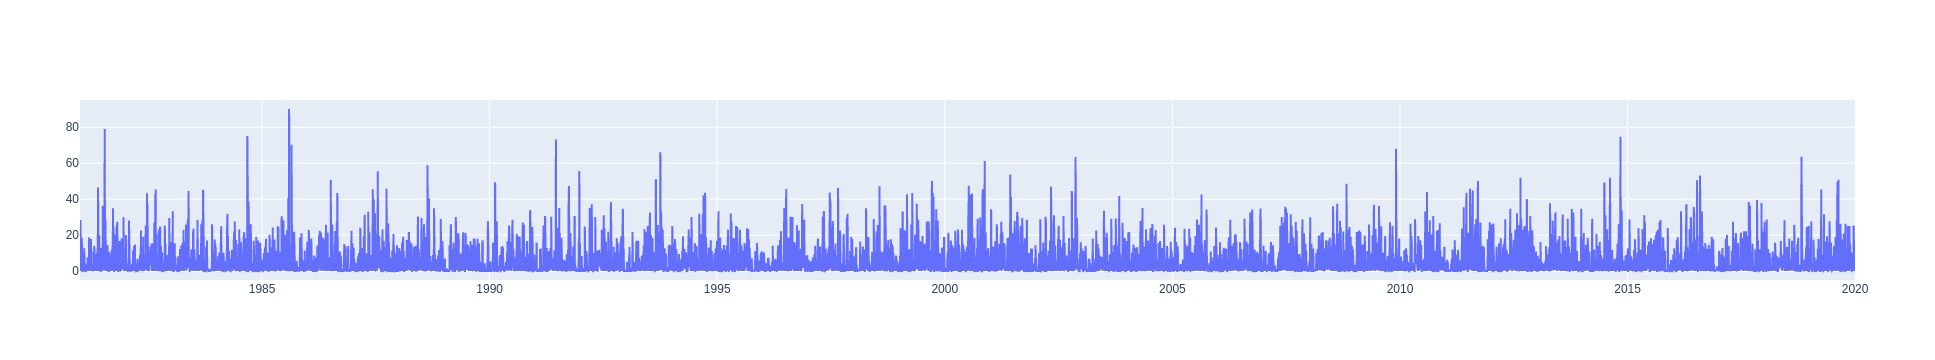

In [13]:
f.show()

In [14]:
# Create a global dataset 
from functools import partial
from multiprocessing import Pool




In [5]:
# Running on multiprocessing in parallel
num_proc = 20
func=partial(read_df)
p = Pool(num_proc)
all_df=list(p.map(func,files))

# Creating one single dataframe and treat the observation as independent (no time correlation)
global_df = pd.concat(all_df) 

# Moving the 'prec' column to last position (convenient)

column_to_move = df.pop("prec")
df.insert(len(df.columns), "prec", column_to_move)

# Inspect the dataframe
df.head(5)

NameError: name 'read_df' is not defined

# Machine Learning Models

The aim of the following section is to implement and use machine learning models to forecast the precipitation value, knowing th eseries of values up to the day the forecats is made.

We use the *sklearn* package for model implementation and the various functionalities to e.g. split the dataset into train and test sets, the RMS metrics, feature importance etc. 


## Preparing the dataset

In the following the prepare and pre-process the dataset.

We consider data from 100 randomly choosen gauges, where we input a fixed random seed for reproducibility purposes.

In [3]:
random_number=1
shuff = True
random.seed(random_number)
if shuff:
    random.shuffle(files)
    files = files[:100]
else:
    files=files[:100]

## Random Forest
will follow https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

a) Naive RF

In this case we consider the data as it is provided, without adding any additional variable.
We will consider a global dataset where all the data of the 100 gauges are combined, and split the dataset into train and test.

We use the *train_test_split()*

In [4]:
try:
    df = df.drop(columns = ['date_time'])
except:
    pass

X_train, X_valid, y_train, y_valid= train_test_split(df.iloc[:, 0:-1],
                                                     df.iloc[:,-1],
                                                     test_size=0.3, 
                                                     random_state=random_number)


NameError: name 'df' is not defined

In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rms = mean_squared_error(y_valid, y_pred, squared=False)

model=RandomForestRegressor(random_state=random_number,max_depth=10,n_jobs=-1)
model.fit(X_train,y_train)
y_pred=model.predict(X_valid)
rms2 = mean_squared_error(y_valid, y_pred, squared=False)

#print(rms2)

3.765058292714067


In [40]:
y_valid.values

array([0.  , 2.32, 2.78, ..., 0.6 , 2.41, 6.75])

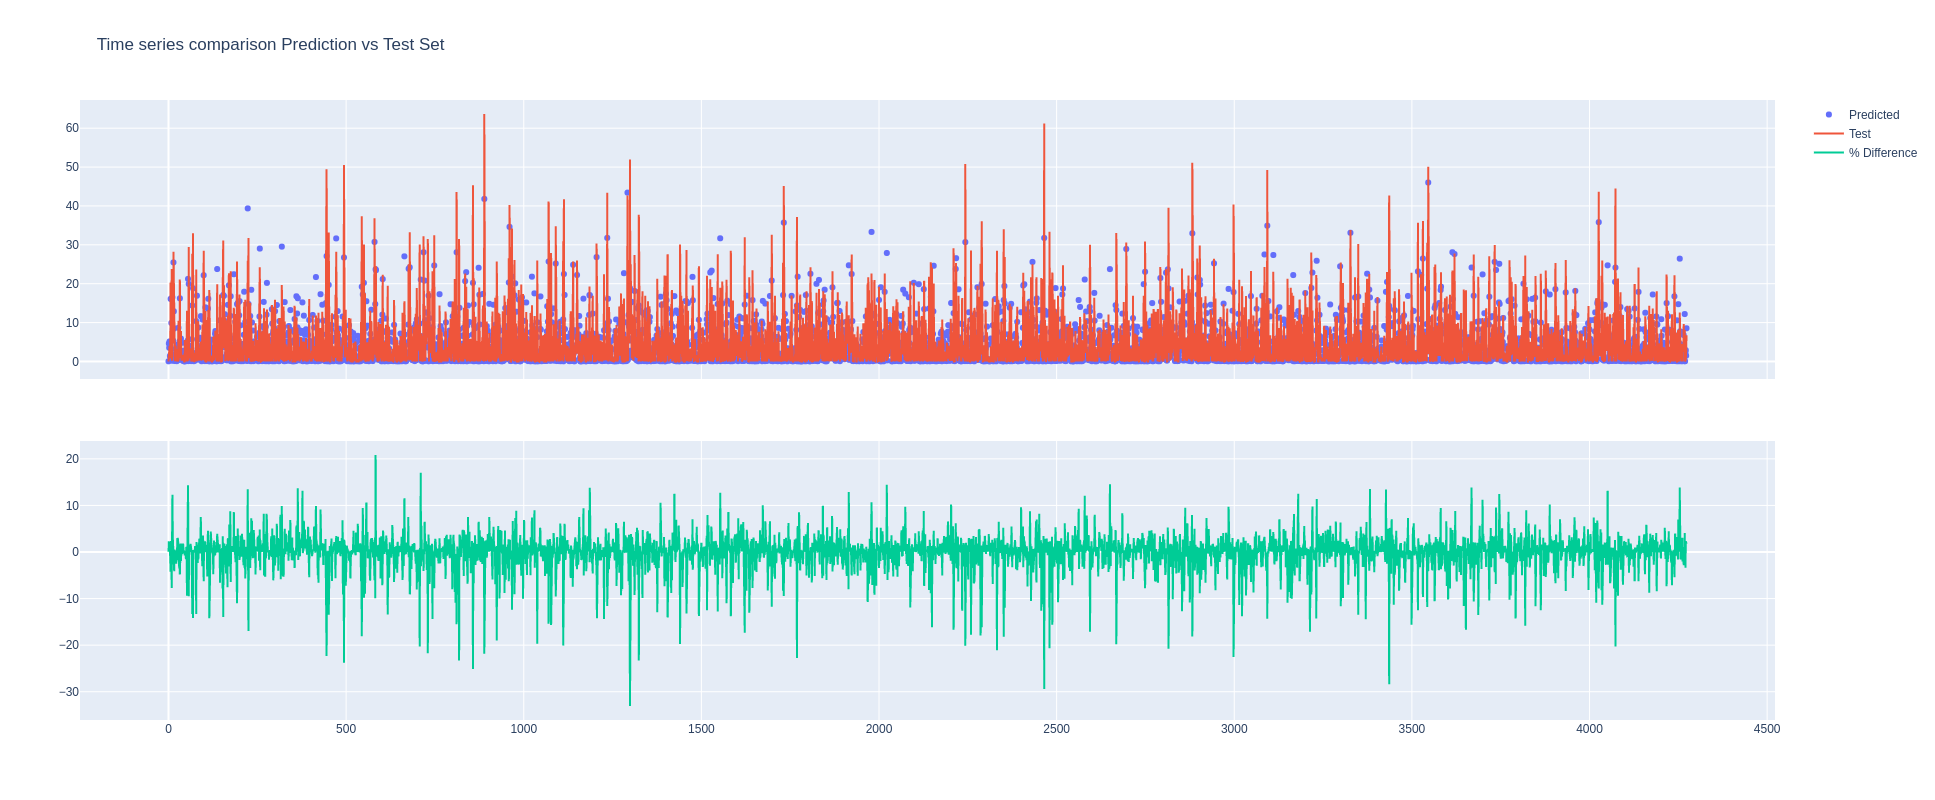

In [60]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create traces
fig = go.Figure()
fig = make_subplots(rows=2, cols=1,
                    shared_xaxes=True,
                    vertical_spacing=0.1,
                   )

fig.add_trace(go.Scatter(x=list(range(len(y_pred))), y=y_pred,
                    mode='markers',
                    name='Predicted'),
              row=1, col=1)

fig.add_trace(go.Scatter(x=list(range(len(y_pred))), y=y_valid,
                    mode='lines',
                    name='Test'),
              row=1, col=1)

"""
fig.add_trace(go.Scatter(x=list(range(len(y_pred))), y=(y_pred - y_valid)/y_valid * 100,
                    mode='lines',
                    name='% Difference'),
              row=2, col=1)
"""

fig.add_trace(go.Scatter(x=list(range(len(y_pred))), y=y_pred - y_valid,
                    mode='lines',
                    name='% Difference'),
              row=2, col=1)


fig.update_layout( title = "Time series comparison Prediction vs Test Set",
                width=1500,
                height=800,
                             )

In [58]:
importance = model.feature_importances_

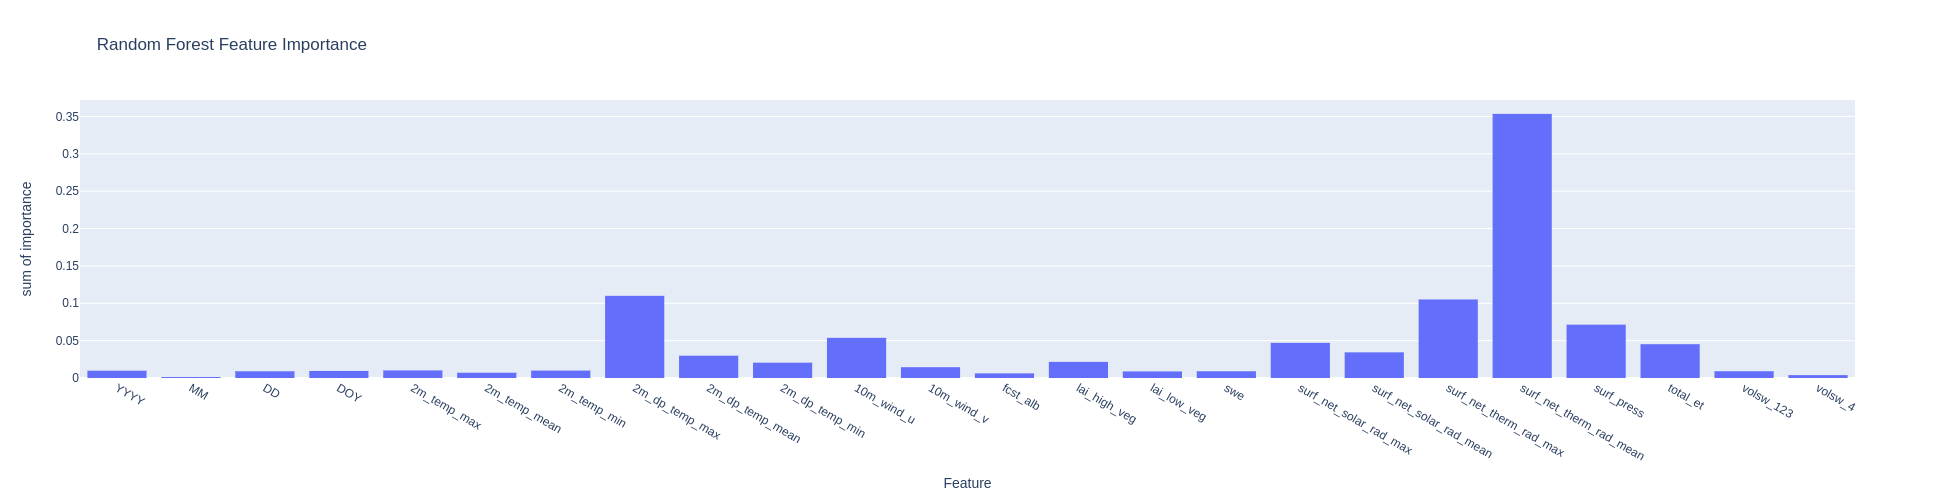

In [65]:
feature_importance=list(zip(importance, X_train.columns))
feature_importance_df=pd.DataFrame(feature_importance,columns=['importance',"Feature"])
fig = px.histogram(feature_importance_df, x="Feature",y='importance',
                  title = 'Random Forest Feature Importance')

fig.update_layout(
                width=1500,
                height=500,)
fig.show()

In [70]:
# Run ensamble of Random Forest models using different set splits
RMS = []

from tqdm import tqdm

ensamble_size = 50
for i in tqdm(range(ensamble_size)):
    X_train, X_valid, y_train, y_valid= train_test_split(df.iloc[:, 0:-1],
                                                     df.iloc[:,-1],
                                                     test_size=0.3, 
                                                     )
    
    model=RandomForestRegressor(max_depth=10,n_jobs=-1)
    model.fit(X_train,y_train)
    y_pred=model.predict(X_valid)
    rms2 = mean_squared_error(y_valid, y_pred, squared=False)
    RMS.append(rms2)
    


100%|██████████| 50/50 [00:23<00:00,  2.11it/s]


In [73]:
fig = px.histogram(RMS)


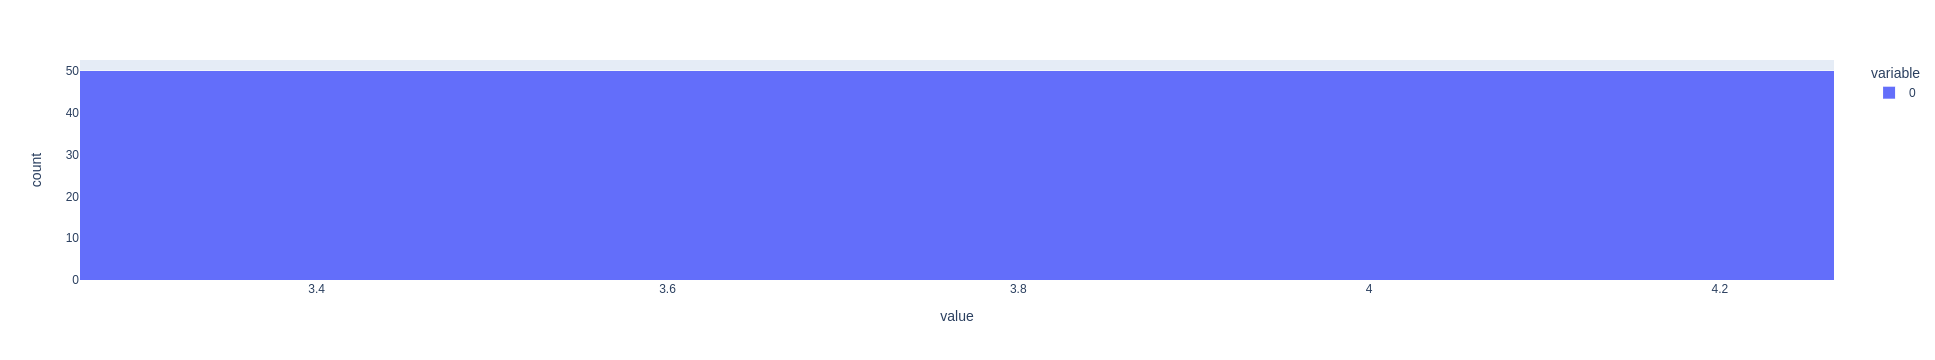

In [74]:
fig.show()

# Ridge Regression

In [ ]:
model=sklearn.linear_model.Ridge()
model.fit(X_train,y_train)
y_pred=model.predict(X_valid)
rms = mean_squared_error(y_valid, y_pred, squared=False)
print(rms)

### Here we can see coefficients of the ridge regression

In [ ]:
importance = model.coef_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %s, Score: %.4f' % (X_train.columns[i],v))

In [ ]:
feature_importance=list(zip(importance, X_train.columns))
feature_importance_df=pd.DataFrame(feature_importance,columns=['importance',"Feature"])
fig = px.histogram(feature_importance_df, x="Feature",y='importance')
fig.show()

## K Neighbors Regressor

In [ ]:
%%time
from sklearn.neighbors import KNeighborsRegressor
model=RandomForestRegressor(n_jobs=-1)
model.fit(X_train,y_train)
y_pred=model.predict(X_valid)
rms3 = mean_squared_error(y_valid, y_pred, squared=False)
print(rms3)

## MLP Regressor

In [ ]:
%%time
from sklearn.neural_network import MLPRegressor
model=MLPRegressor(random_state=random_number)
model.fit(X_train,y_train)
y_pred=model.predict(X_valid)
rms4 = mean_squared_error(y_valid, y_pred, squared=False)
rms4

## Histogram-based Gradient Boosting Regression

In [ ]:
%%time
from sklearn.ensemble import HistGradientBoostingRegressor
model=HistGradientBoostingRegressor(random_state=random_number)
model.fit(X_train,y_train)
y_pred=model.predict(X_valid)
rms4 = mean_squared_error(y_valid, y_pred, squared=False)
rms4